/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


[0.7676078 0.7676078]


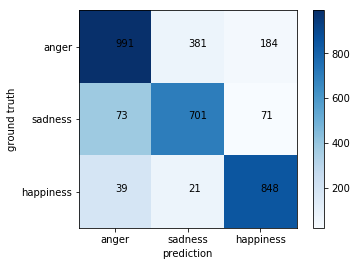

In [3]:
import numpy as np
import csv
import os

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import sklearn

from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt


def _PCA_(A, k):
    pca = PCA(n_components=k)
    U = pca.fit_transform(A)
    V = pca.components_
    S = pca.singular_values_
    return U, V, S


def readCSV(path):
    f = open(path)
    f_csv = csv.reader(f)
    data = []
    label=[]
    next(f_csv)  # skip the head
    for row in f_csv:
        data.append(row[:3])
        label.append(int(row[3]))
    f.close()
    return data, label


def getData(datapath):
    data=np.load(datapath)
    data=np.average(data, axis=0)

    return data


def getTextData(datapath):
    data=np.load(datapath)

    return data


def getFusionData():
    data, label = readCSV('dataset.csv')

    ros = RandomOverSampler(random_state=0)
    data, label = ros.fit_sample(data, label)

    data_v = [a[0] for a in data]
    if os.path.exists('video.npy'):
        x_v = np.load('video.npy')
    else:
        x_v = []
        for i in data_v:
            x_v.append(getData(i))
        np.save('video.npy', x_v)
    data_v = x_v
    scaler = StandardScaler()
    x_v_std = scaler.fit_transform(data_v)
    x_v_std_svm, _, _ = _PCA_(x_v_std, 64)

    data_a = [a[1] for a in data]
    if os.path.exists('audio.npy'):
        x_a = np.load('audio.npy')
    else:
        x_a = []
        for i in data_a:
            x_a.append(getData(i))
        np.save('audio.npy', x_a)
    data_a = x_a
    scaler = StandardScaler()
    x_a_std = scaler.fit_transform(data_a)
    x_a_std_svm, _, _ = _PCA_(x_a_std, 128)

    data_t = [a[2] for a in data]
    if os.path.exists('text.npy'):
        x_t = np.load('text.npy')
    else:
        x_t = []
        for i in data_t:
            x_t.append(getData(i))
        np.save('text.npy', x_t)

    data_t = x_t
    scaler = StandardScaler()
    x_t_std = scaler.fit_transform(data_t)
    x_t_std_svm, _, _ = _PCA_(x_t_std, 128)

    x_std_svm=np.concatenate((x_v_std_svm, x_a_std_svm),axis=1)
    x_std_svm = np.concatenate((x_std_svm, x_t_std_svm), axis=1)

    label = np.array(label)

    return x_std_svm, label


def getParams(x_train, y_train):
    clf = SVC()
    c_range = np.logspace(-4, 4, 10, base=2)
    gamma_range = np.logspace(-9, 1, 10, base=2)

    param_grid = [{'kernel': ['rbf'], 'C': c_range, 'gamma': gamma_range}]
    grid = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1, scoring='f1_micro')
    grid.fit(x_train, y_train)
    best_parameters = grid.best_estimator_.get_params()

    return best_parameters


def svm(x_train, x_test, y_train, y_test, best_parameters):
    clf = SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'])
    clf.fit(x_train, y_train)

    y_ = clf.predict(x_train)
    s = 0
    for i in range(len(y_)):
        if y_[i] == y_train[i]:
            s += 1

    y_p = clf.predict(x_test)
    cm=confusion_matrix(y_test, y_p)

    f1 = sklearn.metrics.f1_score(y_test, y_p, average='micro')
    return s / len(y_), f1, cm


def plotCM(classes, confusion):
    plt.imshow(confusion, cmap=plt.cm.Blues)

    indices = range(len(confusion))

    plt.xticks(indices, classes)
    plt.yticks(indices, classes)

    plt.colorbar()

    plt.xlabel('prediction')
    plt.ylabel('ground truth')

    for first_index in range(len(confusion)):
        for second_index in range(len(confusion[first_index])):
            plt.text(first_index, second_index, confusion[first_index][second_index])


    plt.show()
    
    
def audio():
    data, label = readCSV('dataset.csv')

    ros = RandomOverSampler(random_state=0)
    data, label = ros.fit_sample(data, label)
    data = [a[1] for a in data]

    if os.path.exists('audio.npy'):
        x = np.load('audio.npy')
    else:
        x = []
        for i in data:
            x.append(getData(i))
        np.save('audio.npy', x)

    data = x
    label = np.array(label)

    scaler = StandardScaler()

    x_std = scaler.fit_transform(data)

    kf = KFold(n_splits=10, shuffle=True)



    x_std_svm, _, _ = _PCA_(x_std, 128)  

    if os.path.exists('audioPara.npy'):
        temp = np.load('audioPara.npy')
        best_params={'C':temp[0], 'gamma':temp[1]}
    else:
        best_params = getParams(x_std_svm, label)
        np.save('audioPara.npy', [best_params['C'], best_params['gamma']])


    d = 0, 0
    cm=0

    for train_index, test_index in kf.split(x_std_svm):

        x_train, x_test=x_std_svm[train_index], x_std_svm[test_index]
        y_train, y_test = label[train_index], label[test_index]


        a,b,e = svm(x_train, x_test, y_train, y_test, best_params)

        d+=b
        cm+=e
    
    print(d / 10)
    plotCM(['anger', 'sadness', 'happiness'], cm)
    

    
audio()

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


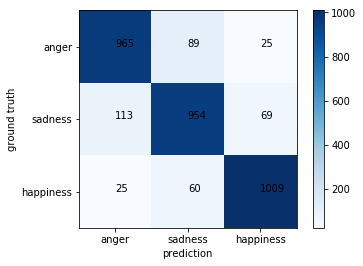

0.8848686258353933


In [4]:
def text():

    data, label = readCSV('dataset.csv')

    ros = RandomOverSampler(random_state=0)
    data, label = ros.fit_sample(data, label)
    data = [a[2] for a in data]

    if os.path.exists('text.npy'):
        x = np.load('text.npy')
    else:
        x = []
        for i in data:
            x.append(getTextData(i))
        np.save('text.npy', x)

    data = np.array(x)

    label = np.array(label)
    scaler = StandardScaler()
    x_std = scaler.fit_transform(data)
    kf = KFold(n_splits=10, shuffle=True)


    x_std_svm, _, _ = _PCA_(x_std, 128)  

    if os.path.exists('textPara.npy'):
        temp = np.load('textPara.npy')
        best_params={'C':temp[0], 'gamma':temp[1]}
    else:
        best_params = getParams(x_std_svm, label)
        np.save('textPara.npy', [best_params['C'], best_params['gamma']])

    #x_std_svm=x_std
    c, d=0,0
    cm=0
    for train_index, test_index in kf.split(x_std_svm):
        x_train, x_test=x_std_svm[train_index], x_std_svm[test_index]
        y_train, y_test = label[train_index], label[test_index]
        a, b, e= svm(x_train, x_test, y_train, y_test, best_params)

        c+=a
        d+=b
        cm+=e

    plotCM(['anger', 'sadness', 'happiness'], cm)
    print(d/10)

text()

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


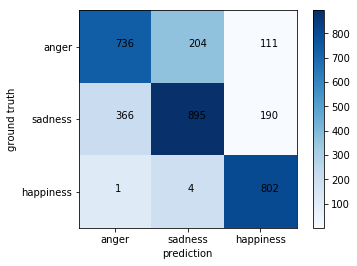

0.7352549665842718


In [5]:
def video():
    data, label = readCSV('dataset.csv')

    ros = RandomOverSampler(random_state=0)
    data, label = ros.fit_sample(data, label)
    data=[a[0] for a in data]

    if os.path.exists('video.npy'):
        x=np.load('video.npy')
    else:
        x=[]
        for i in data:
            x.append(getData(i))
        np.save('video.npy', x)

    data = x
    label = np.array(label)
    scaler = StandardScaler()
    x_std = scaler.fit_transform(data)
    kf = KFold(n_splits=10, shuffle=True)

    x_std_svm, _, _ = _PCA_(x_std, 256)  
    if os.path.exists('videoPara.npy'):
        temp = np.load('videoPara.npy')
        best_params={'C':temp[0], 'gamma':temp[1]}
    else:
        best_params = getParams(x_std_svm, label)
        np.save('videoPara.npy', [best_params['C'], best_params['gamma']])


    c, d = 0, 0
    cm=0

    for train_index, test_index in kf.split(x_std_svm):

        x_train, x_test=x_std_svm[train_index], x_std_svm[test_index]
        y_train, y_test = label[train_index], label[test_index]


        a,b, e = svm(x_train, x_test, y_train, y_test, best_params)
        c+=a
        d+=b
        cm+=e

    plotCM(['anger', 'sadness', 'happiness'], cm)
    print(d / 10)
    
video()

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


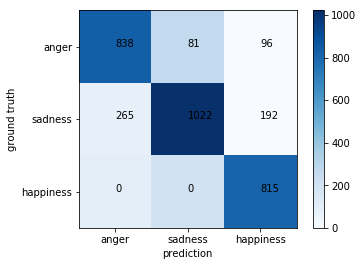

0.8084143550306692


In [6]:
def earlyFusion():
    x_std_svm, label = getFusionData()

    kf = KFold(n_splits=10, shuffle=True)

    if os.path.exists('earlyFusionPara.npy'):
        temp = np.load('earlyFusionPara.npy')
        best_params={'C':temp[0], 'gamma':temp[1]}
    else:
        best_params = getParams(x_std_svm, label)
        np.save('earlyFusionPara.npy', [best_params['C'], best_params['gamma']])

    c, d = 0, 0
    cm=0
    for train_index, test_index in kf.split(x_std_svm):
        x_train, x_test = x_std_svm[train_index], x_std_svm[test_index]
        y_train, y_test = label[train_index], label[test_index]

        a, b, e = svm(x_train, x_test, y_train, y_test, best_params)
        c += a
        d += b
        cm+=e

    plotCM(['anger', 'sadness', 'happiness'], cm)
    print(d / 10)
    
earlyFusion()

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


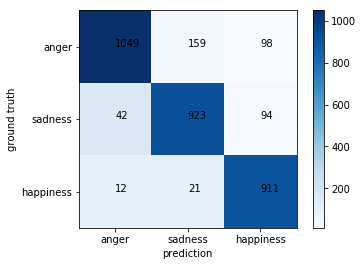

0.8712505721871281


In [7]:
def lateFusion():
    data, label = readCSV('dataset.csv')

    ros = RandomOverSampler(random_state=0)
    data, label = ros.fit_sample(data, label)

    data_v = [a[0] for a in data]
    if os.path.exists('video.npy'):
        x_v = np.load('video.npy')
    else:
        x_v = []
        for i in data_v:
            x_v.append(getData(i))
        np.save('video.npy', x_v)
    data_v = x_v
    scaler = StandardScaler()
    x_v_std = scaler.fit_transform(data_v)
    x_v_std_svm, _, _ = _PCA_(x_v_std, 256)  # svm audio 74

    data_a = [a[1] for a in data]
    if os.path.exists('audio.npy'):
        x_a = np.load('audio.npy')
    else:
        x_a = []
        for i in data_a:
            x_a.append(getData(i))
        np.save('audio.npy', x_a)
    data_a = x_a
    scaler = StandardScaler()
    x_a_std = scaler.fit_transform(data_a)
    x_a_std_svm, _, _ = _PCA_(x_a_std, 128)  # svm audio 74

    data_t = [a[2] for a in data]
    if os.path.exists('text.npy'):
        x_t = np.load('text.npy')
    else:
        x_t = []
        for i in data_t:
            x_t.append(getData(i))
        np.save('text.npy', x_t)

    data_t = x_t
    scaler = StandardScaler()
    x_t_std = scaler.fit_transform(data_t)
    x_t_std_svm, _, _ = _PCA_(x_t_std, 128)

    if os.path.exists('videoPara.npy'):
        temp = np.load('videoPara.npy')
        best_params_v={'C':temp[0], 'gamma':temp[1]}
    else:
        best_params_v = getParams(x_v_std_svm, label)
        np.save('videoPara.npy', [best_params_v['C'], best_params_v['gamma']])


    if os.path.exists('audioPara.npy'):
        temp = np.load('audioPara.npy')
        best_params_a={'C':temp[0], 'gamma':temp[1]}
    else:
        best_params_a = getParams(x_a_std_svm, label)
        np.save('audioPara.npy', [best_params_a['C'], best_params_a['gamma']])


    if os.path.exists('textPara.npy'):
        temp = np.load('textPara.npy')
        best_params_t={'C':temp[0], 'gamma':temp[1]}
    else:
        best_params_t = getParams(x_t_std_svm, label)
        np.save('textPara.npy', [best_params_t['C'], best_params_t['gamma']])

    kf = KFold(n_splits=10, shuffle=True)

    c=0
    cm=0
    for train_index, test_index in kf.split(x_v_std_svm):
        x_v_train, x_v_test = x_v_std_svm[train_index], x_v_std_svm[test_index]
        x_a_train, x_a_test = x_a_std_svm[train_index], x_a_std_svm[test_index]
        x_t_train, x_t_test = x_t_std_svm[train_index], x_t_std_svm[test_index]
        y_train, y_test = label[train_index], label[test_index]

        clf_v = SVC(kernel='rbf', C=best_params_v['C'], gamma=best_params_v['gamma'])
        clf_v.fit(x_v_train, y_train)
        y_v = clf_v.predict(x_v_test)

        clf_a = SVC(kernel='rbf', C=best_params_a['C'], gamma=best_params_a['gamma'])
        clf_a.fit(x_a_train, y_train)
        y_a = clf_a.predict(x_a_test)

        clf_t = SVC(kernel='rbf', C=best_params_t['C'], gamma=best_params_t['gamma'])
        clf_t.fit(x_t_train, y_train)
        y_t = clf_t.predict(x_t_test)

        y_p=[]
        for i in range(len(y_test)):
            y_p.append(Counter([y_a[i],y_v[i],y_t[i], y_t[i]]).most_common(1)[0][0])

        y_p=np.array(y_p)

        f1 = sklearn.metrics.f1_score(y_test, y_p, average='micro')
        c+=f1
        cm+=confusion_matrix(y_test,y_p)

    plotCM(['anger', 'sadness', 'happiness'], cm)
    print(c/10)
    
lateFusion()